In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

This makes the graphs more readable in dark theme
(If you are not using jupyter notebooks in dark theme dont run the cell below)

In [2]:
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

Load data into dataframes

In [3]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [4]:
confirmed = pd.read_csv(confirmed_url, error_bad_lines=False)
deaths = pd.read_csv(deaths_url, error_bad_lines=False)
recovered = pd.read_csv(recovered_url, error_bad_lines=False)

Clean dataframes

In [5]:
confirmed.drop(['Lat','Long','Province/State'], axis = 1, inplace = True)
deaths.drop(['Lat','Long','Province/State'], axis = 1, inplace = True)
recovered.drop(['Lat','Long','Province/State'], axis = 1, inplace = True)

In [6]:
confirmed = confirmed.groupby(['Country/Region']).sum().reset_index()
deaths = deaths.groupby(['Country/Region']).sum().reset_index()
recovered = recovered.groupby(['Country/Region']).sum().reset_index()

In [7]:
# Narrows the dataframes
confirmed = pd.melt(confirmed, id_vars=['Country/Region'], var_name='Date', value_name='Cases')
deaths = pd.melt(deaths, id_vars=['Country/Region'], var_name='Date', value_name='Deaths')
recovered = pd.melt(recovered, id_vars=['Country/Region'], var_name='Date', value_name='Recovered')

In [8]:
confirmed['Date'] = pd.to_datetime(confirmed['Date'])
deaths['Date'] = pd.to_datetime(deaths['Date'])
recovered['Date'] = pd.to_datetime(recovered['Date'])

Calculate days since the 100th Case, Death, Recovery

In [9]:
# Create new column in data frames filled with 0s
dayssince = [0] * len(confirmed.index)
confirmed['DaysSince100thCase'] = dayssince
deaths['DaysSince10thDeath'] = dayssince
recovered['DaysSince10thRecovery'] = dayssince

In [10]:
def days_since_xth_y(x, y, dayssince, dayssinceprevious):
    if y >= x:
        dayssince = dayssinceprevious + 1
    return dayssince


# calculate days since last x
def fill_days_since_column(df, since):
    df100th = []
    for i in range(188):
        currentcountry = pd.DataFrame(df.groupby(['Date']).nth(i)).reset_index()
        for j in range(1,len(df.groupby(['Date']).nth(i).index)):
            currentcountry.iloc[j,3] = days_since_xth_y(since, currentcountry.iloc[j,2], currentcountry.iloc[j,3], currentcountry.iloc[j-1,3])
        currentcountry.iloc[:,3] = currentcountry.iloc[:,3].apply(correct_days_since_column)
        df100th.append(currentcountry)
    return df100th


#removes 1 from each value so counting begins after the day of the 100th x
def correct_days_since_column(n):
    if n > 0:
        n -= 1
    return n

In [11]:
confirmed100th = fill_days_since_column(confirmed, 100)
deaths10th = fill_days_since_column(deaths, 10)
recovered10th = fill_days_since_column(recovered, 10)

Create plots

In [12]:
def create_plot(dflist):
    ax.figure.set_size_inches(15,8)

    yformatter = ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    ax.get_yaxis().set_major_formatter(yformatter)

    #create lists to represent each of the doubling lines
    x = np.arange(0, 16, 1)
    y = (2**x)*100
    plotlist = []
    plotlist.append(np.arange(0, 16, 1))
    plotlist.append(np.arange(0, 32, 2))
    plotlist.append(np.arange(0, 80, 5))
    plotlist.append(np.arange(0, 112, 7))
    plotlist.append(np.arange(0, 224, 14))

    # plot doubling lines
    for i in range(len(plotlist)):
        ax.plot(plotlist[i], y, color = '#383838', linestyle = '--', zorder = 179)

    # plot countries
    for i in range(len(dflist)):
        if i == 83:  # Ireland
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'green', marker = 'o', markevery = 3, zorder = 188, alpha = 0.5)
        elif i == 36:  # China
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'red', marker = 'o', markevery = 3, zorder = 187, alpha = 0.5)
        elif i == 174:  # US
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'blue', marker = 'o', markevery = 3, zorder = 186, alpha = 0.5)
        elif i == 178: # UK
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'brown', marker = 'o', markevery = 3, zorder = 185, alpha = 0.5)
        elif i == 85: # Italy
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'cyan', marker = 'o', markevery = 3, zorder = 184, alpha = 0.5)
        elif i == 91: # South Korea
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'orange', marker = 'o', markevery = 3, zorder = 183, alpha = 0.5)
        elif i == 87: # Japan
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'purple', marker = 'o', markevery = 3, zorder = 182, alpha = 0.5)
        elif i == 158: # Spain
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = '#E1AD01', marker = 'o', markevery = 3, zorder = 181, alpha = 0.5) # mustard
        elif i == 66: # Germany
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2],
                    color = 'pink', marker = 'o', markevery = 3, zorder = 180, alpha = 0.9)
        else:
            ax.plot(dflist[i].iloc[:,3], dflist[i].iloc[:,2], color = '#D3D3D3', alpha = 0.3) # light grey

    plt.grid(True, color = '#E8E8E8') # very light grey

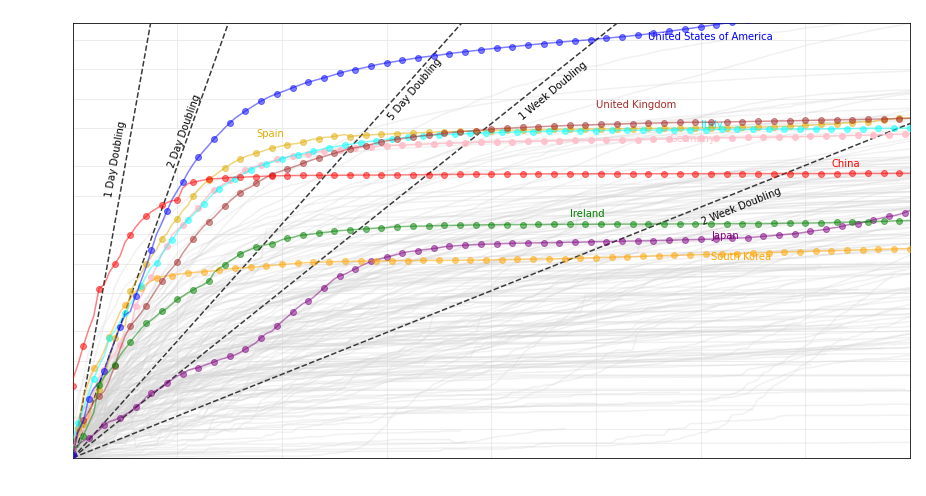

In [13]:
ax = plt.subplot()
plt.ylabel('Number of Cases')
plt.xlabel('Number of Days Since 100th Case')
plt.title('Number of Cases Since 100th Case', color = 'white')

ax.text(95, 30000, 'Ireland', color = 'green')
ax.text(145, 100000, 'China', color = 'red')
ax.text(110, 2000000, 'United States of America', color = 'blue')
ax.text(100, 400000, 'United Kingdom', color = 'brown')
ax.text(120, 250000, 'Italy', color = 'cyan')
ax.text(122, 11000, 'South Korea', color = 'orange')
ax.text(122, 18000, 'Japan', color = 'purple')
ax.text(35, 200000, 'Spain', color = '#E1AD01')
ax.text(114, 180000, 'Germany', color = 'pink')

ax.text(6, 50000, '1 Day Doubling', rotation = 80)
ax.text(18, 100000, '2 Day Doubling', rotation = 70)
ax.text(60, 300000, '5 Day Doubling', rotation = 50)
ax.text(85, 300000, '1 Week Doubling', rotation = 40)
ax.text(120, 25000, '2 Week Doubling', rotation = 22)

ax.set_ylim(100, 3000000)
ax.set_yscale('log')
ax.get_yaxis().get_major_formatter().labelOnlyBase = False
ax.set_yticks([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000,
               100000, 250000, 500000, 1000000, 2000000, 3000000])
ax.set_xlim(0, 160)

create_plot(confirmed100th)
    
plt.show()

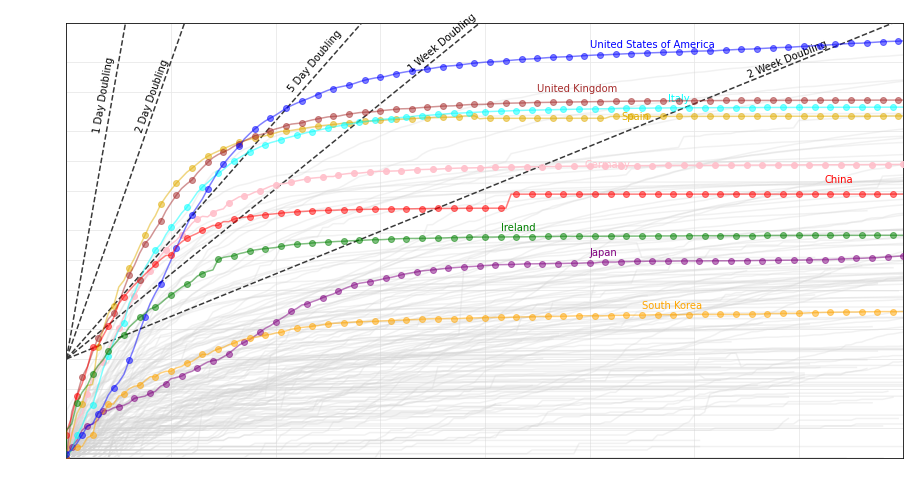

In [14]:
ax = plt.subplot()
plt.ylabel('Number of Deaths')
plt.xlabel('Number of Days Since 10th Death')
plt.title('Number of Deaths Since 10th Death', color = 'white')

ax.text(83, 2000, 'Ireland', color = 'green')
ax.text(145, 6000, 'China', color = 'red')
ax.text(100, 140000, 'United States of America', color = 'blue')
ax.text(90, 50000, 'United Kingdom', color = 'brown')
ax.text(115, 40000, 'Italy', color = 'cyan')
ax.text(110, 320, 'South Korea', color = 'orange')
ax.text(100, 1100, 'Japan', color = 'purple')
ax.text(106, 26000, 'Spain', color = '#E1AD01')
ax.text(99, 8500, 'Germany', color = 'pink')

ax.text(5, 20000, '1 Day Doubling', rotation = 80)
ax.text(13, 20000, '2 Day Doubling', rotation = 70)
ax.text(42, 50000, '5 Day Doubling', rotation = 50)
ax.text(65, 80000, '1 Week Doubling', rotation = 40)
ax.text(130, 70000, '2 Week Doubling', rotation = 22)

ax.set_ylim(10, 250000)
ax.set_yscale('log')
ax.get_yaxis().get_major_formatter().labelOnlyBase = False
ax.set_yticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000,
               100000, 250000])
ax.set_xlim(0, 160)
ax.set_xlim(0, 160)

create_plot(deaths10th)
    
plt.show()

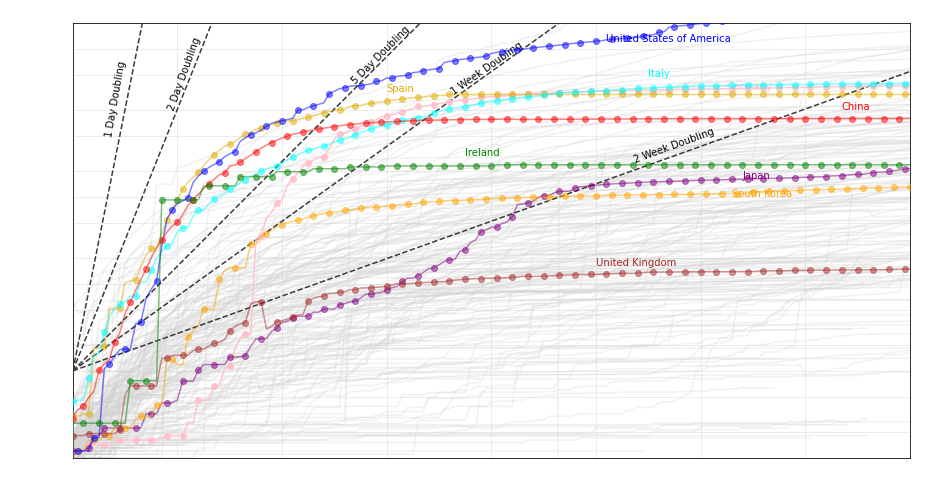

In [15]:
ax = plt.subplot()
plt.ylabel('Number of Recoveries')
plt.xlabel('Number of Days Since 10th Recovery')
plt.title('Number of Recoveries Since 10th Recovery', color = 'white')

ax.text(75, 30000, 'Ireland', color = 'green')
ax.text(147, 100000, 'China', color = 'red')
ax.text(102, 600000, 'United States of America', color = 'blue')
ax.text(100, 1600, 'United Kingdom', color = 'brown')
ax.text(110, 240000, 'Italy', color = 'cyan')
ax.text(126, 10000, 'South Korea', color = 'orange')
ax.text(128, 16000, 'Japan', color = 'purple')
ax.text(60, 160000, 'Spain', color = '#E1AD01')
ax.text(125, 170000, 'Germany', color = 'pink')

ax.text(6, 50000, '1 Day Doubling', rotation = 80)
ax.text(18, 100000, '2 Day Doubling', rotation = 70)
ax.text(53, 200000, '5 Day Doubling', rotation = 45)
ax.text(72, 150000, '1 Week Doubling', rotation = 35)
ax.text(107, 25000, '2 Week Doubling', rotation = 20)

ax.set_ylim(10, 1000000)
ax.set_yscale('log')
ax.get_yaxis().get_major_formatter().labelOnlyBase = False
ax.set_yticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000,
               100000, 250000, 500000, 1000000])
ax.set_xlim(0, 160)
ax.set_xlim(0, 160)

create_plot(recovered10th)
    
plt.show()